# sklearn-LDA

## 预处理

In [3]:
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg

In [4]:
output_path = 'lda/result'
file_path = 'lda/data'
# os.chdir(file_path)
data=pd.read_excel("笔记详情_2025-03-29 copy.xlsx")#content type
# os.chdir(output_path)
dic_file = "stop_dic/dict.txt"
stop_file = "stop_dic/baidu_stopwords.txt"

In [5]:
# 修改后的分词函数
def chinese_word_cut(mytext, keep_words=None):
    # 初始化保留词列表
    if keep_words is None:
        keep_words = []
    elif isinstance(keep_words, str):
        keep_words = [keep_words]
    
    jieba.load_userdict(dic_file)
    jieba.initialize()
    try:
        stopword_list = open(stop_file, encoding='utf-8')
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n', 'nz', 'vn']
    # flag_list = ['n', 'nz', 'vn', 'v', 'nr']  # 添加更多词性
    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)
    
    word_list = []
    # jieba分词
    seg_list = psg.cut(mytext)
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]', '', seg_word.word)
        
        # 如果词在保留词列表中，直接添加并跳过过滤
        if word in keep_words and word:
            word_list.append(word)
            continue
            
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word) < 2:  # this word is stopword
                find = 1
                break
        if find == 0 and seg_word.flag in flag_list:
            word_list.append(word)      
    return (" ").join(word_list)

In [6]:
# keep_words = ['大觉禅寺', '大觉寺', '冰箱贴', '手串']

data["content"] = data["content"].astype(str)
data["笔记内容_CUT"] = data.content.apply(lambda x: chinese_word_cut(x))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\quzhe\AppData\Local\Temp\jieba.cache
Loading model cost 0.631 seconds.
Prefix dict has been built successfully.


## LDA分析

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [8]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [9]:
n_features = 200 #提取200个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10)

tf = tf_vectorizer.fit_transform(data.笔记内容_CUT)

In [10]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
#                                 doc_topic_prior=0.1,
#                                 topic_word_prior=0.01,
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(learning_offset=50, max_iter=50, n_components=5,
                          random_state=0)

### 输出每个主题对应词语 

In [11]:
n_top_words = 25
tf_feature_names = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
祈福 石鱼 寺庙 财神 停车场 咖啡 旅行 摸鱼 门票 时间 旅游 事业 景区 盲盒 院子 路线 流杯 公交 学业 梨树 地方 观音殿 禅意 交通 观音洞
Topic #1:
冰箱贴 流沙 设计 石鱼 元素 旅游 狐狸 文化 生活 建筑 梨花 五福 色彩 画面 传统 百事 热门 旅行 地标 梨树 建议 姐妹 历史 产品 项链
Topic #2:
消费 天坛 免费 游览 门票 游客 景区 集章 亲子 建议 线路 步行 冰箱贴 游玩 摊位 景点 旅游 景观 洞口 对面 创店 小时 文化 检票 石鱼
Topic #3:
公园 产品 旧物 空间 石鱼 邮局 景区 祈福 门票 明信片 免费 单向 品牌 宠物 文艺 生活 咖啡 下午茶 小时 植物 路线 美景 价格 艺术 扫码
Topic #4:
手串 公园 琉璃 咖啡 门头沟 素食 流通 免费 生活 石鱼 法物 套餐 建议 排队 餐厅 摸鱼 地方 停车场 寺庙 小伙伴 历史 味道 炸酱面 时间 感觉


### 输出每篇文章对应主题 

In [12]:
import numpy as np

In [13]:
topics=lda.transform(tf)

In [14]:
topic = []
for t in topics:
    topic.append(list(t).index(np.max(t)))
data['topic']=topic
data.to_excel("data_topic.xlsx",index=False)

In [15]:
topics[0]#0 1 2 

array([0.06865702, 0.54622196, 0.00673538, 0.15144304, 0.2269426 ])

## 可视化 

In [16]:
import pyLDAvis
import pyLDAvis.lda_model

In [17]:
pyLDAvis.enable_notebook()
# pic = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pic = pyLDAvis.lda_model.prepare(lda, tf, tf_vectorizer, n_jobs=1)
pyLDAvis.save_html(pic, 'lda_pass'+str(n_topics)+'.html')
# pyLDAvis.show(pic)

## 困惑度 

In [18]:
import matplotlib.pyplot as plt

In [19]:
plexs = []
scores = []
n_max_topics = 16
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


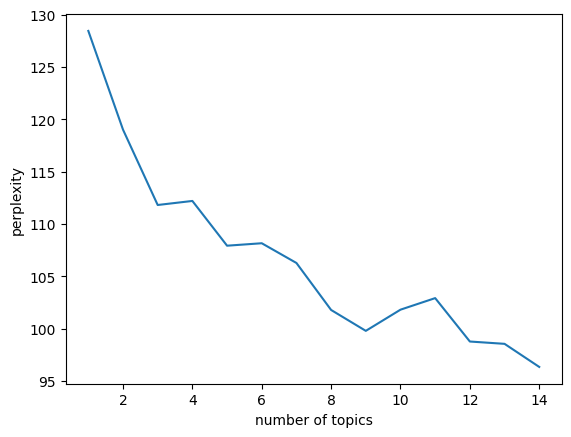

In [20]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,plexs[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()

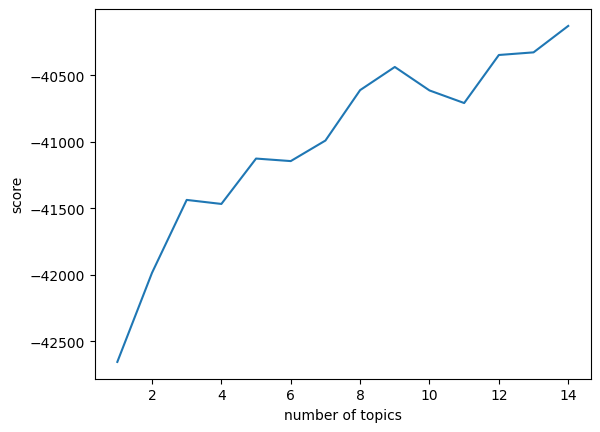

In [21]:
n_t=15#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t))
plt.plot(x,scores[1:n_t])
plt.xlabel("number of topics")
plt.ylabel("score")
plt.show()